## Bootstrapping

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(fable))
suppressMessages(library(tsibble))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))

plot_prefix <- 'plots/w12_'

### Decomposition on Cement

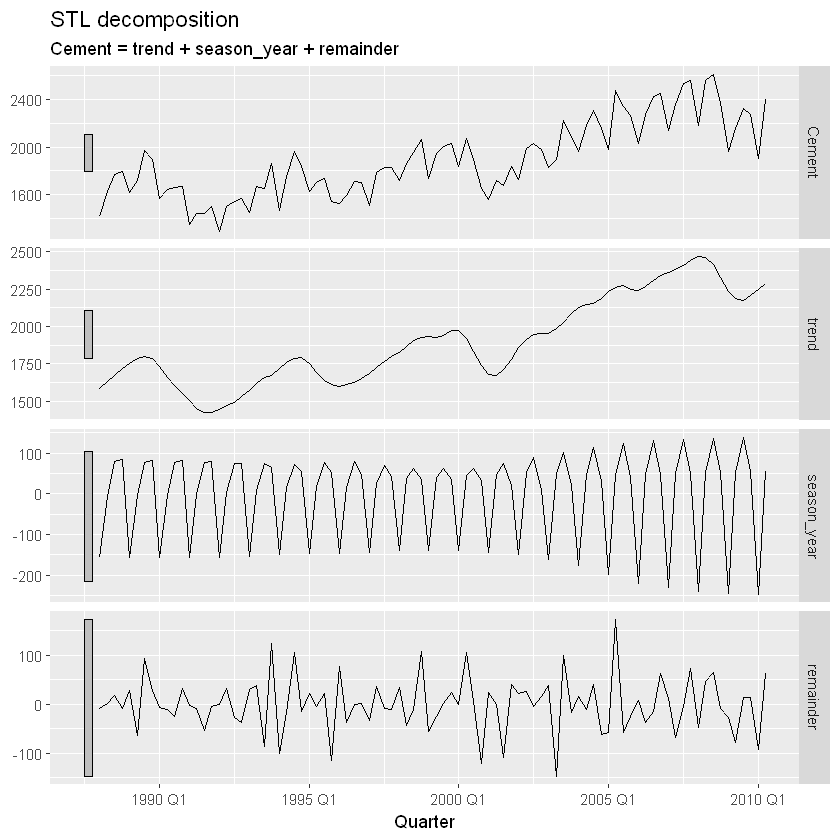

In [2]:
cement <- aus_production |>
  filter(year(Quarter) >= 1988) |>
  select(Quarter, Cement)

cement_stl <- cement |>
  model(stl = STL(Cement))

cement_stl |>
  components() |>
  autoplot()

ggsave(paste(plot_prefix, 'cement_decomp.png', sep=''), height=5, width=3)

### Bootstrap

Plot variable not specified, automatically selected `.vars = Cement`


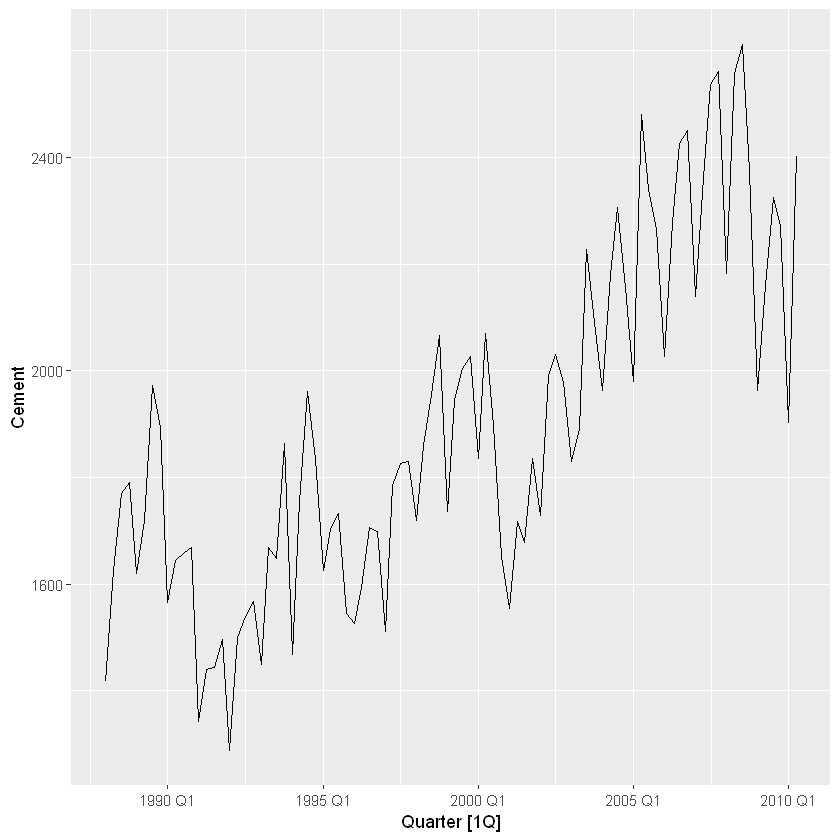

In [3]:
cement %>% autoplot()

ggsave(paste(plot_prefix, 'cement_1.png', sep=''), height=4, width=4)

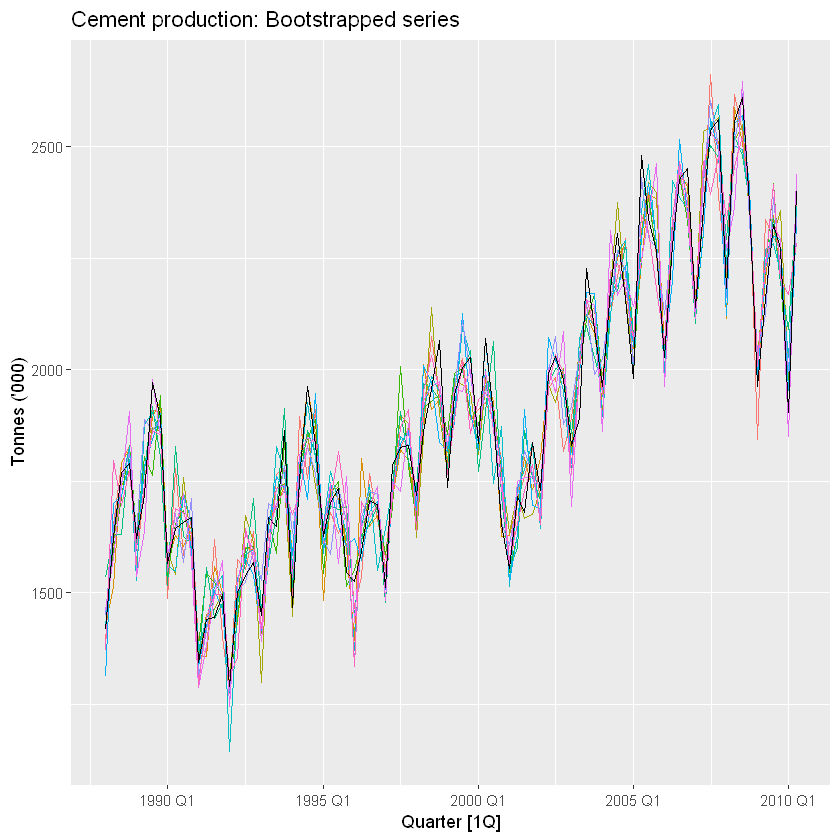

In [4]:
cement_stl |>
  generate(new_data = cement, times = 10,
           bootstrap_block_size = 8) |>
  autoplot(.sim) +
  autolayer(cement, Cement) +
  guides(colour = "none") +
  labs(title = "Cement production: Bootstrapped series",
       y="Tonnes ('000)")

ggsave(paste(plot_prefix, 'cement_boot.png', sep=''), height=4, width=4)

### Baseline

In [5]:
cement_train <- cement %>% filter_index(. ~ '2007 Q4')
cement_test <- cement %>% filter_index('2008 Q1' ~ .)

In [6]:
cement_models <- cement_train %>%
model(
    'ARIMA' = ARIMA(Cement),
    'ETS' = ETS(Cement)
)

cement_models %>% accuracy()

.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ARIMA,Training,-6.20649,100.1195,79.88824,-0.6704966,4.372392,0.5458024,0.5823004,-0.01134009
ETS,Training,12.78539,102.5243,80.00890,0.4267255,4.405643,0.5466268,0.5962871,-0.05276269


In [7]:
cement_model_forecasts <- cement_models %>% forecast(cement_test)

cement_model_forecasts %>% accuracy(cement_test)

.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ARIMA,Test,-160.5363,216.4332,185.5033,-7.711827,8.676720,NaN,NaN,0.3870161
ETS,Test,-170.8256,222.0420,190.9648,-8.070537,8.852066,NaN,NaN,0.5793787


### Bagged Forecasts

In [8]:
cement_stl_model <- cement_train |>
  model(stl = STL(Cement))

In [9]:
boots <- cement_stl_model |>
  generate(new_data = cement_train, times = 100,
           bootstrap_block_size = 8) |>
  select(-.model, -Cement)

In [10]:
cement_boot_models <- boots |>
  model('ETS' = ETS(.sim), 'ARIMA' = ARIMA(.sim))

In [11]:
cement_boot_forecasts <- cement_boot_models %>% forecast(h=10)

In [14]:
bagged <- cement_boot_forecasts |>
  group_by(.model) %>%
  summarise(bagged_mean = mean(.mean))

bagged

.model,Quarter,bagged_mean
<chr>,<qtr>,<dbl>
ARIMA,2008 Q1,2287.620
ARIMA,2008 Q2,2514.470
ARIMA,2008 Q3,2576.161
ARIMA,2008 Q4,2509.658
ARIMA,2009 Q1,2287.894
ARIMA,2009 Q2,2496.063
ARIMA,2009 Q3,2554.817
ARIMA,2009 Q4,2499.558
ARIMA,2010 Q1,2279.961


In [21]:
bagged_ets <- bagged %>%
filter(.model == 'ETS') %>%
select(-.model)

bagged_arima <- bagged %>%
filter(.model == 'ARIMA') %>%
select(-.model)

forecast::accuracy(bagged_ets$bagged_mean, cement_test$Cement)
forecast::accuracy(bagged_arima$bagged_mean, cement_test$Cement)

,ME,RMSE,MAE,MPE,MAPE
Test set,-178.868,235.8022,204.1274,-8.536975,9.514749


,ME,RMSE,MAE,MPE,MAPE
Test set,-174.964,224.8786,190.8378,-8.3118,8.926561


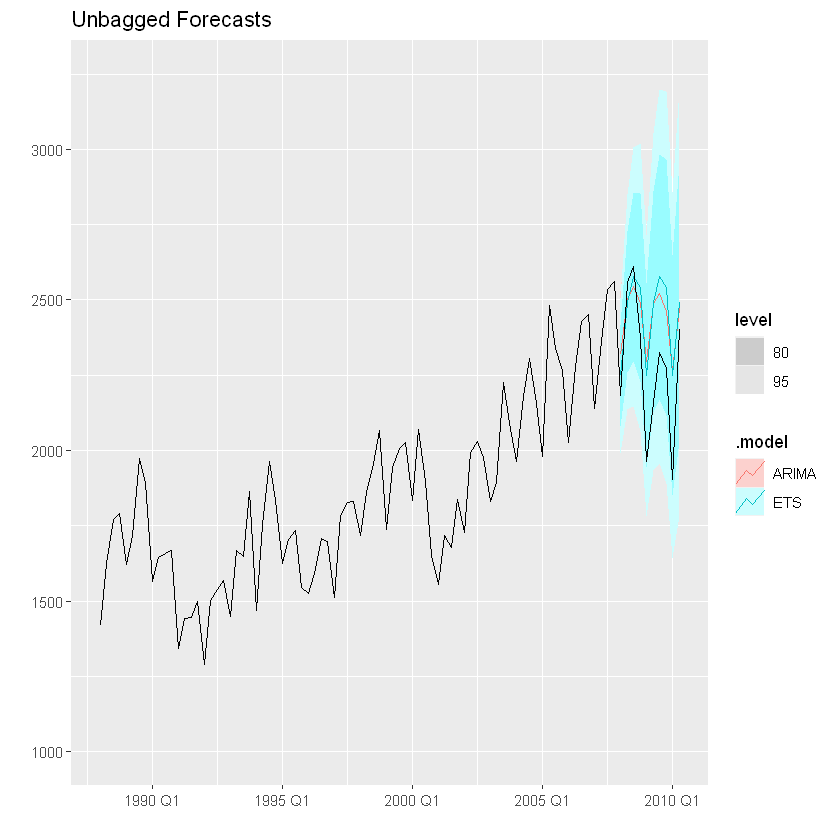

In [59]:
cement_model_forecasts %>% autoplot() + autolayer(cement, Cement) +
labs(title = 'Unbagged Forecasts', y='', x='') + ylim(1000, 3250)

ggsave(paste(plot_prefix, 'cement_unbagged_forecasts.png', sep=''), height=4, width=4)

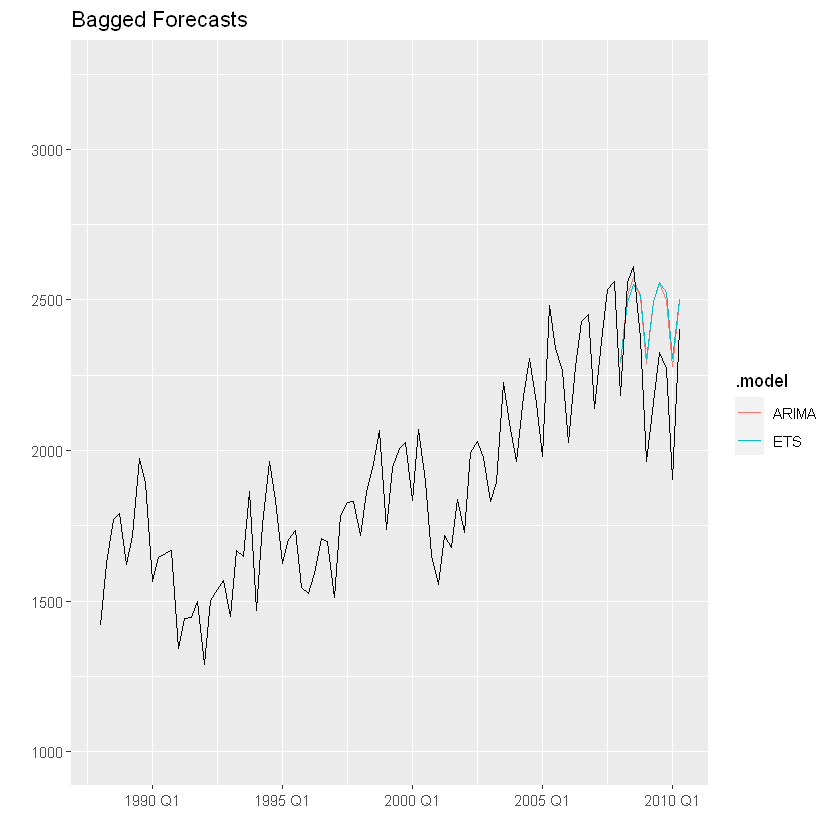

In [60]:
bagged %>% autoplot(bagged_mean) + autolayer(cement, Cement) +
labs(title = 'Bagged Forecasts', y='', x='')+ ylim(1000, 3250)

ggsave(paste(plot_prefix, 'cement_bagged_forecasts.png', sep=''), height=4, width=4)